## SED Fitting Analysis

---

### Imports

In [4]:
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import scipy
import matplotlib
from astropy.constants import c
from matplotlib.patches import Rectangle
from labellines import labelLines
from scipy.optimize import root, curve_fit
from scipy.stats import pearsonr, spearmanr, binned_statistic
from itertools import compress
from astropy.cosmology import Planck18 as cosmo
utils.rcparams()

In [2]:
# Load the data and gather the primary and secondary samples
list_sources = utils.full_loader('catalogue_combined.csv')
primary_sample = list_sources[list_sources['sample'] == 2]
primary_sample = primary_sample.reset_index()

# Split samples into SPT and HerBS sources
spt_sample = primary_sample[primary_sample['spt_herbs'] == 1]
herbs_sample = primary_sample[primary_sample['spt_herbs'] == 2]
spt_sample = spt_sample.reset_index()
herbs_sample = herbs_sample.reset_index()

print('Number of SPT sources = {}'.format(len(spt_sample)))
print('Number of HerBS sources = {}'.format(len(herbs_sample)))

Number of SPT sources = 79
Number of HerBS sources = 30


In [3]:
# Assumed cosmology
cosmo

FlatLambdaCDM(name='Planck18', H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.30966, Tcmb0=<Quantity 2.7255 K>, Neff=3.046, m_nu=<Quantity [0.  , 0.  , 0.06] eV>, Ob0=0.04897)

In [12]:
# Load optically thin results
spt_catalogue_ot, spt_catalogue_ot_df = utils.load_catalogue('model_results', 'spt_catalogue_ot'), utils.load_catalogue('model_results', 'spt_catalogue_ot_summary')
herbs_catalogue_ot, herbs_catalogue_ot_df = utils.load_catalogue('model_results', 'herbs_catalogue_ot'), utils.load_catalogue('model_results', 'herbs_catalogue_ot_summary')

# Load general opacity (100 microns) results
spt_catalogue_go100, spt_catalogue_go100_df = utils.load_catalogue('model_results', 'spt_catalogue_go_100'), utils.load_catalogue('model_results', 'spt_catalogue_go_100_summary')
herbs_catalogue_go100, herbs_catalogue_go100_df = utils.load_catalogue('model_results', 'herbs_catalogue_go_100'), utils.load_catalogue('model_results', 'herbs_catalogue_go_100_summary')

# Load general opacity (200 microns) results
spt_catalogue_go200, spt_catalogue_go200_df = utils.load_catalogue('model_results', 'spt_catalogue_go_200'), utils.load_catalogue('model_results', 'spt_catalogue_go_200_summary')
herbs_catalogue_go200, herbs_catalogue_go200_df = utils.load_catalogue('model_results', 'herbs_catalogue_go_200'), utils.load_catalogue('model_results', 'herbs_catalogue_go_200_summary')

# Load general opacity (known continuum area) results
spt_catalogue_gor, spt_catalogue_gor_df = utils.load_catalogue('model_results', 'spt_catalogue_go_r'), utils.load_catalogue('model_results', 'spt_catalogue_go_r_summary')

---

### Important Statistics

#### Redshifts

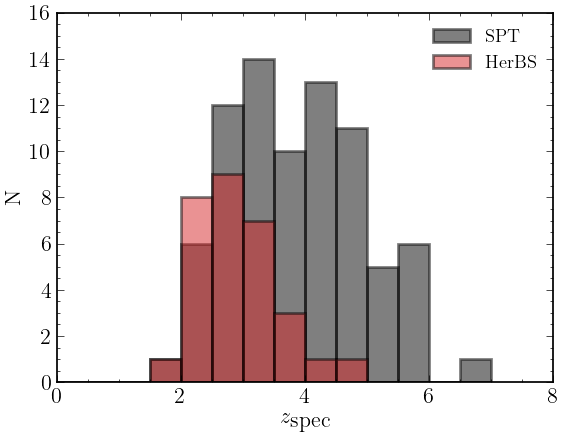

In [5]:
# Redshift range and number of bins
z_range = (0,7)
z_bins = 14

fig, ax = plt.subplots()
ax.hist(spt_sample['zspec'], bins=z_bins, ec='k', fc='k', linewidth=2, alpha=0.5, range=z_range, label='SPT')
ax.hist(herbs_sample['zspec'], bins=z_bins, ec='k', fc='tab:red', linewidth=2, alpha=0.5, range=z_range, label='HerBS')
ax.set_xlabel(r'$z_{\textrm{spec}}$')
ax.set_ylabel(r'N')
ax.set_xlim(0, 8)
ax.set_ylim(0, 16)
ax.legend()
plt.savefig(os.getcwd()+'/figures/Figure_4_2.pdf', dpi=1000)
plt.show()

In [6]:
# Median redshifts
herbs_z_median = np.median(herbs_sample['zspec'])
spt_z_median = np.median(spt_sample['zspec'])

print('The median redshift of HerBS galaxies = {:.3f}'.format(herbs_z_median))
print('The median redshift of SPT galaxies = {:.3f}'.format(spt_z_median))

# Range of redshifts
print('The range of redshifts of HerBS galaxies = {:.3f} - {:.3f}'.format(np.min(herbs_sample['zspec']), np.max(herbs_sample['zspec'])))
print('The range of redshifts of SPT galaxies = {:.3f} - {:.3f}'.format(np.min(spt_sample['zspec']), np.max(spt_sample['zspec'])))

The median redshift of HerBS galaxies = 2.728
The median redshift of SPT galaxies = 3.862
The range of redshifts of HerBS galaxies = 1.569 - 4.509
The range of redshifts of SPT galaxies = 1.867 - 6.901


#### Wavelength Coverage

In [13]:
# Minimum and maximum wavelengths
min_wavelengths_spt, max_wavelengths_spt = [min(spt_catalogue_ot[it].wavelength_rest_um) for it in range(len(spt_catalogue_ot))], [max(spt_catalogue_ot[it].wavelength_rest_um) for it in range(len(spt_catalogue_ot))]
min_wavelengths_herbs, max_wavelengths_herbs = [min(herbs_catalogue_ot[it].wavelength_rest_um) for it in range(len(herbs_catalogue_ot))], [max(herbs_catalogue_ot[it].wavelength_rest_um) for it in range(len(herbs_catalogue_ot))]
print('The minimum possible coverage of SPT sources is {:.0f}um < rest wavelength < {:.0f}um'.format(max(min_wavelengths_spt), min(max_wavelengths_spt)))
print('The minimum possible coverage of HerBS sources is {:.0f}um < rest wavelength < {:.0f}um'.format(max(min_wavelengths_herbs), min(max_wavelengths_herbs)))

The minimum possible coverage of SPT sources is 83um < rest wavelength < 380um
The minimum possible coverage of HerBS sources is 97um < rest wavelength < 392um


#### Lensing Magnification

In [14]:
# Minimum and maximum lensing magnifications
print('Lensing magnifications of SPT sources range between {:.1f} - {:.1f}'.format(min(spt_sample['mag']), max(spt_sample['mag'])))
print('Lensing magnifications of HerBS sources range between {:.1f} - {:.1f}'.format(min(herbs_sample['mag']), max(herbs_sample['mag'])))

# Median lensing magnifications
spt_mag_median = np.nanmedian(spt_sample['mag'])
herbs_mag_median = np.nanmedian(herbs_sample['mag'])
print('Median lensing magnifications of SPT sources = {:.1f}'.format(spt_mag_median))
print('Median lensing magnifications of HerBS sources = {:.1f}'.format(herbs_mag_median))

Lensing magnifications of SPT sources range between 1.0 - 32.7
Lensing magnifications of HerBS sources range between 0.4 - 49.8
Median lensing magnifications of SPT sources = 5.5
Median lensing magnifications of HerBS sources = 5.3


---

### Far-IR / Sub-mm Colours

In [7]:
def colour_z(lam_um_1, lam_um_2, z, theta, opacity_model):
    """
    Calculates the colour at a given redshift
    
    :param lam_um_1: First wavelength [microns]
    :param lam_um_2: Second wavelength [microns]
    :param z: Redshift
    :param theta: Fitting parameters
    :param opacity_model: Dust opacity assumption
    :return: Colour
    """
    nu_1, nu_2 = c.value/(lam_um_1*1e-6), c.value/(lam_um_2*1e-6)
    nu_1_rest, nu_2_rest = nu_1*(1+z), nu_2*(1+z)
    s_1 = utils.get_model(nu_1_rest, z, theta, m=1, opacity_model=opacity_model, powerlaw=False)
    s_2 = utils.get_model(nu_2_rest, z, theta, m=1, opacity_model=opacity_model, powerlaw=False)
    return s_1/s_2

def colour_error(flux_1, flux_2, error_1, error_2):
    """
    Calculates the colour and its error
    
    :param flux_1: First flux density
    :param flux_2: Second flux density
    :param error_1: Error on first flux density
    :param error_2: Error on second flux density
    :return: Colour and error on colour
    """
    colour = flux_1/flux_2
    colour_error = np.sqrt(((error_1/flux_1)**2) + ((error_2/flux_2)**2))*colour
    return colour, colour_error

def colour_redshift_plot(lam_um_1, lam_um_2, ylabel, name, ymax=100):
    """
    Generates a plot of colour against redshift

    :param lam_um_1: First wavelength [microns]
    :param lam_um_2: Second wavelength [microns]
    :param ylabel: Label for y-axis
    :param name: Figure file name
    :param ymax: Maximum y-value on plot (Default = 100)
    """
    # Obtain colours and their errors for all SPT and HerBS galaxies
    spt_colours, spt_colours_err = colour_error(spt_sample['S_'+str(lam_um_1)], spt_sample['S_'+str(lam_um_2)], spt_sample['E_'+str(lam_um_1)], spt_sample['E_'+str(lam_um_2)])
    herbs_colours, herbs_colours_err = colour_error(herbs_sample['S_'+str(lam_um_1)], herbs_sample['S_'+str(lam_um_2)], herbs_sample['E_'+str(lam_um_1)], herbs_sample['E_'+str(lam_um_2)])

    # Define redshift range, x, y, and y error lists
    alpha=0.25
    z_range = np.linspace(0,8,1000)
    sample_labels = ["SPT", "HerBS"]
    x_list = [spt_sample['zspec'], herbs_sample['zspec']]
    y_list = [spt_colours, herbs_colours]
    yerr_list = [spt_colours_err, herbs_colours_err]
    fc_list = ['gray', 'tab:red']

    fig, ax = plt.subplots()
    # Plot colours as error bars
    for x,y,yerr,fc,label in zip(x_list,y_list,yerr_list,fc_list,sample_labels):
        markers, caps, bars = ax.errorbar(x, y, yerr=yerr, c='k', fmt='o', markerfacecolor=fc, label=label)
        [bar.set_alpha(alpha) for bar in bars]
        [cap.set_alpha(alpha) for cap in caps]

    # Plot Optically Thin (T = 30, beta = 2) model
    col = colour_z(lam_um_1, lam_um_2, z_range, [1, 30, 2], 'thin')
    ax.plot(z_range, col, c='k', linestyle='-', label=r'MBB$_{\textrm{\small Thin}}$ ($T = 30\,K, \beta = 2$)')

    # Plot Optically Thin (T = 30, beta = 1.8) model
    col = colour_z(lam_um_1, lam_um_2, z_range, [1, 30, 1.8], 'thin')
    ax.plot(z_range, col, c='k', linestyle='--', label=r'MBB$_{\textrm{\small Thin}}$ ($T = 30\,K, \beta = 1.8$)')

    # Plot Optically Thin (T = 40, beta = 2) model
    col = colour_z(lam_um_1, lam_um_2, z_range, [1, 40, 2], 'thin')
    ax.plot(z_range, col, c='k', linestyle=':', label=r'MBB$_{\textrm{\small Thin}}$ ($T = 40\,K, \beta = 2$)')
    ax.set_xlabel(r'$z_{\textrm{spec}}$')
    ax.set_ylabel(ylabel)
    ax.set_xlim(1,8)
    ax.set_ylim(0, ymax)
    ax.legend(fontsize=10)
    plt.savefig(utils.ROOT+'/figures/'+str(name)+'.pdf', dpi=1000)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_4324/3858131689.py:16: RuntimeWarning: invalid value encountered in divide
  return s_1/s_2


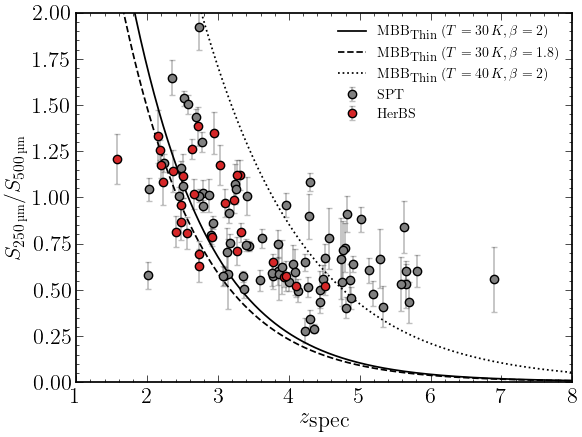

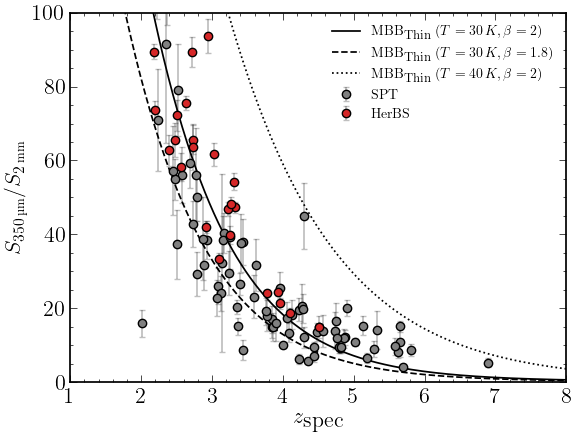

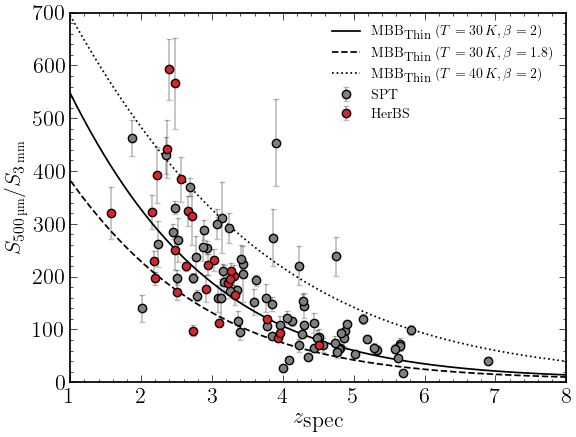

In [11]:
# Plot of S250/S500
colour_redshift_plot(250, 500, r'$S_{\small 250\,\textrm{\textmu m}}/S_{\small 500\,\textrm{\textmu m}}$', "Figure_4_3_part1", ymax=2)

# Plot of S350/S2
colour_redshift_plot(350, 2000, r'$S_{\small 350\,\textrm{\textmu m}}/S_{\small 2\,\textrm{mm}}$', "Figure_4_3_part2", ymax=100)

# Plot of S500/S3
colour_redshift_plot(500, 3000, r'$S_{\small 500\,\textrm{\textmu m}}/S_{\small 3\,\textrm{mm}}$', "Figure_4_3_part3", ymax=700)

---

### SED Results

#### Combine Model Results

In [16]:
# Create copies of each model
spt_catalogue_ot_df_copy = spt_catalogue_ot_df.copy()
spt_catalogue_go100_df_copy = spt_catalogue_go100_df.copy()
spt_catalogue_go200_df_copy = spt_catalogue_go200_df.copy()
spt_catalogue_gor_df_copy = spt_catalogue_gor_df.copy()

herbs_catalogue_ot_df_copy = herbs_catalogue_ot_df.copy()
herbs_catalogue_go100_df_copy = herbs_catalogue_go100_df.copy()
herbs_catalogue_go200_df_copy = herbs_catalogue_go200_df.copy()

# Add the name of the model to the end of the column names
spt_catalogue_ot_df_copy.columns = spt_catalogue_ot_df_copy.columns.map(lambda x: str(x) + '_ot')
spt_catalogue_go100_df_copy.columns = spt_catalogue_go100_df_copy.columns.map(lambda x: str(x) + '_go100')
spt_catalogue_go200_df_copy.columns = spt_catalogue_go200_df_copy.columns.map(lambda x: str(x) + '_go200')
spt_catalogue_gor_df_copy.columns = spt_catalogue_gor_df_copy.columns.map(lambda x: str(x) + '_gor')

herbs_catalogue_ot_df_copy.columns = herbs_catalogue_ot_df_copy.columns.map(lambda x: str(x) + '_ot')
herbs_catalogue_go100_df_copy.columns = herbs_catalogue_go100_df_copy.columns.map(lambda x: str(x) + '_go100')
herbs_catalogue_go200_df_copy.columns = herbs_catalogue_go200_df_copy.columns.map(lambda x: str(x) + '_go200')

# Consecutively merge each model with another
spt_catalogue_results_df = pd.merge(pd.merge(pd.merge(spt_catalogue_ot_df_copy, spt_catalogue_go100_df_copy, left_on=('id_ot'), right_on=('id_go100')), spt_catalogue_go200_df_copy, left_on=('id_ot'), right_on=('id_go200')), spt_catalogue_gor_df_copy, left_on=('id_ot'), right_on=('id_gor'), how='outer')
herbs_catalogue_results_df = pd.merge(pd.merge(herbs_catalogue_ot_df_copy, herbs_catalogue_go100_df_copy, left_on=('id_ot'), right_on=('id_go100')), herbs_catalogue_go200_df_copy, left_on=('id_ot'), right_on=('id_go200'))

# Isolate sources with known continuum areas
spt_r_index = spt_catalogue_results_df['r_gor'] > 0
spt_catalogue_go100_r = list(compress(spt_catalogue_go100, spt_r_index))
spt_catalogue_go200_r = list(compress(spt_catalogue_go200, spt_r_index))
print('The number of SPT sources with size measurements = {}'.format(np.sum(spt_r_index)))

The number of SPT sources with size measurements = 37


#### Posterior Distributions

In [17]:
def get_full_sample(catalogue, param: str, n=5000):
    """
    Returns a random subset of the posterior distribution

    :param catalogue: Catalogue of sources
    :param param: Dust parameter of interest
    :param n: Number of samples (Default = 5000)
    :return: Array of parameter estimates
    """
    return np.concatenate([np.random.choice(catalogue[it].sample_full[:,catalogue[0].params_full.index(param)], n, replace=False) for it in range(len(catalogue))]).ravel().tolist()

# Define parameter ranges for plots
log_m_range = (8,11)
log_mu_m_range = (8.5,11)
t_range = (10,80)
beta_range = (0.5,4)
lir_range = (12,14.5)
lir_mu_range = (12.75,14.5)
peak_wave_range = (25,150)
log_m_bins = t_bins = beta_bins = lir_bins = peak_wave_bins = 20

In [19]:
# Obtain dust mass posterior
spt_ot_logmum_full, spt_go100_logmum_full, spt_go200_logmum_full, spt_gor_logmum_full = get_full_sample(spt_catalogue_ot, "log_mu_m"), get_full_sample(spt_catalogue_go100, "log_mu_m"), get_full_sample(spt_catalogue_go200, "log_mu_m"), get_full_sample(spt_catalogue_gor, "log_mu_m")
herbs_ot_logmum_full, herbs_go100_logmum_full, herbs_go200_logmum_full = get_full_sample(herbs_catalogue_ot, "log_mu_m"), get_full_sample(herbs_catalogue_go100, "log_mu_m"), get_full_sample(herbs_catalogue_go200, "log_mu_m")

# Obtain dust temperature posterior
spt_ot_t_full, spt_go100_t_full, spt_go200_t_full, spt_gor_t_full = get_full_sample(spt_catalogue_ot, "t"), get_full_sample(spt_catalogue_go100, "t"), get_full_sample(spt_catalogue_go200, "t"), get_full_sample(spt_catalogue_gor, "t")
herbs_ot_t_full, herbs_go100_t_full, herbs_go200_t_full = get_full_sample(herbs_catalogue_ot, "t"), get_full_sample(herbs_catalogue_go100, "t"), get_full_sample(herbs_catalogue_go200, "t")

# Obtain dust emissivity spectral index posterior
spt_ot_beta_full, spt_go100_beta_full, spt_go200_beta_full, spt_gor_beta_full = get_full_sample(spt_catalogue_ot, "beta"), get_full_sample(spt_catalogue_go100, "beta"), get_full_sample(spt_catalogue_go200, "beta"), get_full_sample(spt_catalogue_gor, "beta")
herbs_ot_beta_full, herbs_go100_beta_full, herbs_go200_beta_full = get_full_sample(herbs_catalogue_ot, "beta"), get_full_sample(herbs_catalogue_go100, "beta"), get_full_sample(herbs_catalogue_go200, "beta")

# Obtain log(mu LIR) posterior
spt_ot_logmulir_full, spt_go100_logmulir_full, spt_go200_logmulir_full, spt_gor_logmulir_full = get_full_sample(spt_catalogue_ot, "log_mu_LIR"), get_full_sample(spt_catalogue_go100, "log_mu_LIR"), get_full_sample(spt_catalogue_go200, "log_mu_LIR"), get_full_sample(spt_catalogue_gor, "log_mu_LIR")
herbs_ot_logmulir_full, herbs_go100_logmulir_full, herbs_go200_logmulir_full = get_full_sample(herbs_catalogue_ot, "log_mu_LIR"), get_full_sample(herbs_catalogue_go100, "log_mu_LIR"), get_full_sample(herbs_catalogue_go200, "log_mu_LIR")

# Obtain peak wavelength posterior
spt_ot_wavepeak_full, spt_go100_wavepeak_full, spt_go200_wavepeak_full, spt_gor_wavepeak_full = get_full_sample(spt_catalogue_ot, "peak_wave"), get_full_sample(spt_catalogue_go100, "peak_wave"), get_full_sample(spt_catalogue_go200, "peak_wave"), get_full_sample(spt_catalogue_gor, "peak_wave")
herbs_ot_wavepeak_full, herbs_go100_wavepeak_full, herbs_go200_wavepeak_full = get_full_sample(herbs_catalogue_ot, "peak_wave"), get_full_sample(herbs_catalogue_go100, "peak_wave"), get_full_sample(herbs_catalogue_go200, "peak_wave")

# Create parameter lists combining the arrays from above
logmum_param_list = [[spt_ot_logmum_full, spt_go100_logmum_full, spt_go200_logmum_full, spt_gor_logmum_full], [herbs_ot_logmum_full, herbs_go100_logmum_full, herbs_go200_logmum_full]]
t_param_list = [[spt_ot_t_full, spt_go100_t_full, spt_go200_t_full, spt_gor_t_full], [herbs_ot_t_full, herbs_go100_t_full, herbs_go200_t_full]]
beta_param_list = [[spt_ot_beta_full, spt_go100_beta_full, spt_go200_beta_full, spt_gor_beta_full], [herbs_ot_beta_full, herbs_go100_beta_full, herbs_go200_beta_full]]
logmulir_param_list = [[spt_ot_logmulir_full, spt_go100_logmulir_full, spt_go200_logmulir_full, spt_gor_logmulir_full], [herbs_ot_logmulir_full, herbs_go100_logmulir_full, herbs_go200_logmulir_full]]
wavepeak_param_list = [[spt_ot_wavepeak_full, spt_go100_wavepeak_full, spt_go200_wavepeak_full, spt_gor_wavepeak_full], [herbs_ot_wavepeak_full, herbs_go100_wavepeak_full, herbs_go200_wavepeak_full]]

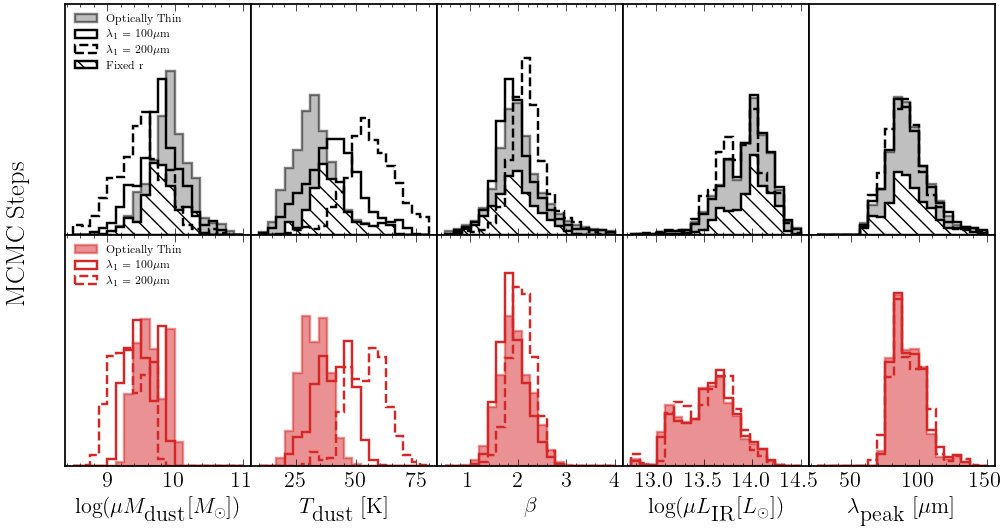

In [20]:
# Plot styles
ec_list = ['k','tab:red']
fc_list = [['gray', 'w', 'w', 'w'], ['tab:red', 'w', 'w', 'w']]
histtype_list = ['stepfilled', 'step', 'step', 'stepfilled']
linestyle_list = ['-','-','--','-']
hatch_list = ['', '', '', r'\\']
alpha_list = [0.5, 1, 1, 1]
label_list = ['Optically Thin', r'$\lambda_1$ = 100$\mu$m', r'$\lambda_1$ = 200$\mu$m', 'Fixed r']

fig, ax = plt.subplots(2,5,sharey='row',figsize=(12,6))

# Dust mass posterior distributions
for ax_it,ec,fc_set,param_set in zip(range(len(ax)),ec_list,fc_list,logmum_param_list):
    for param,fc,linestyle,histtype,hatch,alpha,label in zip(param_set,fc_set,linestyle_list,histtype_list,hatch_list,alpha_list,label_list):
        ax[ax_it,0].hist(param, hatch=hatch, bins=log_m_bins, range=log_mu_m_range, histtype=histtype, ec=ec, fc=fc, alpha=alpha, linestyle=linestyle, linewidth=1.75, label=label)
        ax[ax_it,0].set_yticks([])
        ax[ax_it,0].legend(fontsize=8, loc='upper left')

# Dust temperature posterior distributions
for ax_it,ec,fc_set,param_set in zip(range(len(ax)),ec_list,fc_list,t_param_list):
    for param,fc,linestyle,histtype,hatch,alpha,label in zip(param_set,fc_set,linestyle_list,histtype_list,hatch_list,alpha_list,label_list):
        ax[ax_it,1].hist(param, hatch=hatch, bins=t_bins, range=t_range, histtype=histtype, ec=ec, fc=fc, alpha=alpha, linestyle=linestyle, linewidth=1.75, label=label)
        ax[ax_it,1].set_yticks([])

# Dust emissivity spectral index posterior distributions
for ax_it,ec,fc_set,param_set in zip(range(len(ax)),ec_list,fc_list,beta_param_list):
    for param,fc,linestyle,histtype,hatch,alpha,label in zip(param_set,fc_set,linestyle_list,histtype_list,hatch_list,alpha_list,label_list):
        ax[ax_it,2].hist(param, hatch=hatch, bins=beta_bins, range=beta_range, histtype=histtype, ec=ec, fc=fc, alpha=alpha, linestyle=linestyle, linewidth=1.75, label=label)
        ax[ax_it,2].set_xticks([1,2,3,4])
        ax[ax_it,2].set_yticks([])

# IR luminosity posterior distributions
for ax_it,ec,fc_set,param_set in zip(range(len(ax)),ec_list,fc_list,logmulir_param_list):
    for param,fc,linestyle,histtype,hatch,alpha,label in zip(param_set,fc_set,linestyle_list,histtype_list,hatch_list,alpha_list,label_list):
        ax[ax_it,3].hist(param, hatch=hatch, bins=lir_bins, range=lir_mu_range, histtype=histtype, ec=ec, fc=fc, alpha=alpha, linestyle=linestyle, linewidth=1.75, label=label)
        ax[ax_it,3].set_xticks([13,13.5,14,14.5])
        ax[ax_it,3].set_yticks([])

# Peak wavelength posterior distributions
for ax_it,ec,fc_set,param_set in zip(range(len(ax)),ec_list,fc_list,wavepeak_param_list):
    for param,fc,linestyle,histtype,hatch,alpha,label in zip(param_set,fc_set,linestyle_list,histtype_list,hatch_list,alpha_list,label_list):
        ax[ax_it,4].hist(param, hatch=hatch, bins=peak_wave_bins, range=peak_wave_range, histtype=histtype, ec=ec, fc=fc, alpha=alpha, linestyle=linestyle, linewidth=1.75, label=label)
        ax[ax_it,4].set_yticks([])
ax[0,-1].set_xticks([])
ax[0,0].set_ylim(0,1.2e5)
ax[-1,0].set_ylim(0,5e4)
ax[-1,0].set_xlabel(r'$\textrm{log}(\mu M_\textrm{dust} [M_{\odot}])$')
ax[-1,1].set_xlabel(r'$T_{\textrm{dust}}$ [K]')
ax[-1,2].set_xlabel(r'$\beta$')
ax[-1,3].set_xlabel(r'$\textrm{log}(\mu L_{\textrm{IR}} [L_{\odot}])$')
ax[-1,4].set_xlabel(r'$\lambda_{\textrm{peak}}$ [$\mu$m]')
plt.subplots_adjust(wspace=0, hspace=0)
fig.supylabel('MCMC Steps', x=0.075)
plt.savefig(os.getcwd() + '/figures/Figure_4_5.pdf', dpi=1000)
plt.show()

In [25]:
# Get optically thick wavelength and continuum size from opposite model
spt_gor_lambdathick_full = get_full_sample(spt_catalogue_gor, "lambda_thick")
spt_go100_r_full = get_full_sample(spt_catalogue_go100, "r")
spt_go200_r_full = get_full_sample(spt_catalogue_go200, "r")

# Range and median value of optically thick wavelength (from r model)
low, median, high = np.percentile(spt_gor_lambdathick_full, [16,50,84])
print('SPT (r) lambda thick median = {:.2f}-{:.2f}+{:.2f}'.format(median, median-low, high-median))
print('SPT (r) lambda thick range = {:.2f}-{:.2f}'.format(median-low, median+high))

# Range and median value of continuum size (from optically thick wavelength model)
low, median, high = np.percentile(spt_go100_r_full, [16,50,84])
print('SPT (100um) r range and median = {:.2f}-{:.2f}+{:.2f}'.format(median, median-low, high-median))

low, median, high = np.percentile(spt_go200_r_full, [16,50,84])
print('SPT (200um) r range and median = {:.2f}-{:.2f}+{:.2f}'.format(median, median-low, high-median))

SPT (r) lambda thick median = 87.68-43.83+48.75
SPT (r) lambda thick range = 43.83-224.10
SPT (100um) r range and median = 0.90-0.37+0.83
SPT (200um) r range and median = 0.42-0.14+0.17


#### Median (Best-fitting) Parameters

In [29]:
# Full dust mass posteriors
logmum_param_full = [spt_ot_logmum_full, spt_go100_logmum_full, spt_go200_logmum_full, spt_gor_logmum_full, herbs_ot_logmum_full, herbs_go100_logmum_full, herbs_go200_logmum_full]

# Full dust temperature posteriors
t_param_full = [spt_ot_t_full, spt_go100_t_full, spt_go200_t_full, spt_gor_t_full, herbs_ot_t_full, herbs_go100_t_full, herbs_go200_t_full]

# Full dust emissivity spectral index posteriors
beta_param_full = [spt_ot_beta_full, spt_go100_beta_full, spt_go200_beta_full, spt_gor_beta_full, herbs_ot_beta_full, herbs_go100_beta_full, herbs_go200_beta_full]

# Full IR luminosity posteriors
logmulir_param_full = [spt_ot_logmulir_full, spt_go100_logmulir_full, spt_go200_logmulir_full, spt_gor_logmulir_full, herbs_ot_logmulir_full, herbs_go100_logmulir_full, herbs_go200_logmulir_full]

# Full peak wavelength posteriors
wavepeak_param_full = [spt_ot_wavepeak_full, spt_go100_wavepeak_full, spt_go200_wavepeak_full, spt_gor_wavepeak_full, herbs_ot_wavepeak_full, herbs_go100_wavepeak_full, herbs_go200_wavepeak_full]

# Combine posteriors and define labels
all_param_full = [logmum_param_full, t_param_full, beta_param_full, logmulir_param_full, wavepeak_param_full]
all_param_names = ['log(uM)', 'T', 'beta', 'log(uLIR)', 'Peak Wave']
param_order = ['SPT (Optically Thin)', 'SPT (100-micron)', 'SPT (200-micron)', 'SPT (Fixed r)', 'HerBS (Optically Thin)', 'HerBS (100-micron)', 'HerBS (200-micron)']

# Print median values
for param_list,name_list in zip(all_param_full,all_param_names):
    print('\n********** '+name_list+' **********\n')
    for param,order in zip(param_list,param_order):
        print(order)
        low, median, high = np.percentile(param, [16,50,84])
        print(name_list+' = {:.2f}-{:.2f}+{:.2f}'.format(median, median-low, high-median))


********** log(uM) **********

SPT (Optically Thin)
log(uM) = 9.92-0.31+0.30
SPT (100-micron)
log(uM) = 9.77-0.34+0.31
SPT (200-micron)
log(uM) = 9.49-0.41+0.37
SPT (Fixed r)
log(uM) = 9.78-0.23+0.33
HerBS (Optically Thin)
log(uM) = 9.62-0.22+0.30
HerBS (100-micron)
log(uM) = 9.49-0.22+0.31
HerBS (200-micron)
log(uM) = 9.30-0.26+0.33

********** T **********

SPT (Optically Thin)
T = 32.06-8.45+8.45
SPT (100-micron)
T = 40.75-11.75+10.91
SPT (200-micron)
T = 55.62-9.28+11.20
SPT (Fixed r)
T = 38.60-6.82+9.76
HerBS (Optically Thin)
T = 32.73-5.91+5.86
HerBS (100-micron)
T = 41.16-8.25+7.47
HerBS (200-micron)
T = 55.11-9.15+7.29

********** beta **********

SPT (Optically Thin)
beta = 1.98-0.39+0.54
SPT (100-micron)
beta = 1.91-0.32+0.50
SPT (200-micron)
beta = 2.18-0.30+0.38
SPT (Fixed r)
beta = 1.92-0.44+0.46
HerBS (Optically Thin)
beta = 1.92-0.32+0.39
HerBS (100-micron)
beta = 1.85-0.25+0.34
HerBS (200-micron)
beta = 2.08-0.24+0.26

********** log(uLIR) **********

SPT (Optically Th

In [30]:
alpha = 0.25
spt_mfc_list = ['gray', 'w']
spt_mec_list = ['k', 'k']
herbs_mfc_list = ['tab:red', 'w']
herbs_mec_list = ['k', 'tab:red']

# Define range of SPT dust parameters for plotting
log_m_um_range_spt = np.linspace(8.25,11,1000)
t_range_spt = np.linspace(10,85,1000)
beta_range_spt = np.linspace(0.5,4,1000)
logmulir_range_spt = np.linspace(13,14.5,1000)
peakwave_range_spt = np.linspace(60,160,1000)

# Define range of HerBS dust parameters for plotting
log_m_um_range_herbs = np.linspace(8.75,10.25,1000)
t_range_herbs = np.linspace(20,75,1000)
beta_range_herbs = np.linspace(1,3,1000)
logmulir_range_herbs = np.linspace(12.5,14,1000)
peakwave_range_herbs = np.linspace(70,140,1000)

# Set x and y ticks for each parameter
ranges_spt = [log_m_um_range_spt, t_range_spt, beta_range_spt, logmulir_range_spt, peakwave_range_spt]
ticks_spt = [[8.5,9,9.5,9.5,10,10.5,11], [20,30,40,50,60,70,80], [1,1.5,2,2.5,3,3.5,4], [13.25,13.5,13.75,14,14.25,14.5], [70,90,110,130,150]]
ranges_herbs = [log_m_um_range_herbs, t_range_herbs, beta_range_herbs, logmulir_range_herbs, peakwave_range_herbs]
ticks_herbs = [[9,9.25,9.5,9.75,10,10.25], [30,40,50,60,70], [1,1.5,2,2.5,3], [12.75,13,13.25,13.5,13.75,14], [80,90,100,110,120,130,140]]

# SPT optically thin best fitting values
spt_ot_best_list = [[spt_catalogue_results_df['logmum_ot'], spt_catalogue_results_df['logmum_ot']],[spt_catalogue_results_df['t_ot'], spt_catalogue_results_df['t_ot']],[spt_catalogue_results_df['beta_ot'], spt_catalogue_results_df['beta_ot']],[spt_catalogue_results_df['logmulir_ot'], spt_catalogue_results_df['logmulir_ot']], [spt_catalogue_results_df['peakwave_ot'], spt_catalogue_results_df['peakwave_ot']]]

# SPT optically thin error values
spt_ot_err_best_list = [[(spt_catalogue_results_df['logmum_low_ot'],spt_catalogue_results_df['logmum_high_ot']), (spt_catalogue_results_df['logmum_low_ot'],spt_catalogue_results_df['logmum_high_ot'])],[(spt_catalogue_results_df['t_low_ot'],spt_catalogue_results_df['t_high_ot']), (spt_catalogue_results_df['t_low_ot'],spt_catalogue_results_df['t_high_ot'])],[(spt_catalogue_results_df['beta_low_ot'],spt_catalogue_results_df['beta_high_ot']), (spt_catalogue_results_df['beta_low_ot'],spt_catalogue_results_df['beta_high_ot'])],[(spt_catalogue_results_df['logmulir_low_ot'],spt_catalogue_results_df['logmulir_high_ot']), (spt_catalogue_results_df['logmulir_low_ot'],spt_catalogue_results_df['logmulir_high_ot'])], [(spt_catalogue_results_df['peakwave_low_ot'],spt_catalogue_results_df['peakwave_high_ot']), (spt_catalogue_results_df['peakwave_low_ot'],spt_catalogue_results_df['peakwave_high_ot'])]]

# SPT general opacity best fitting values
spt_go_best_list = [[spt_catalogue_results_df['logmum_go100'], spt_catalogue_results_df['logmum_go200']],[spt_catalogue_results_df['t_go100'], spt_catalogue_results_df['t_go200']],[spt_catalogue_results_df['beta_go100'], spt_catalogue_results_df['beta_go200']],[spt_catalogue_results_df['logmulir_go100'], spt_catalogue_results_df['logmulir_go200']], [spt_catalogue_results_df['peakwave_go100'], spt_catalogue_results_df['peakwave_go200']]]

# SPT optically thin error values
spt_go_err_best_list = [[(spt_catalogue_results_df['logmum_low_go100'],spt_catalogue_results_df['logmum_high_go100']), (spt_catalogue_results_df['logmum_low_go200'],spt_catalogue_results_df['logmum_high_go200'])],[(spt_catalogue_results_df['t_low_go100'],spt_catalogue_results_df['t_high_go100']), (spt_catalogue_results_df['t_low_go200'],spt_catalogue_results_df['t_high_go200'])],[(spt_catalogue_results_df['beta_low_go100'],spt_catalogue_results_df['beta_high_go100']), (spt_catalogue_results_df['beta_low_go200'],spt_catalogue_results_df['beta_high_go200'])],[(spt_catalogue_results_df['logmulir_low_go100'],spt_catalogue_results_df['logmulir_high_go100']), (spt_catalogue_results_df['logmulir_low_go200'],spt_catalogue_results_df['logmulir_high_go200'])], [(spt_catalogue_results_df['peakwave_low_go100'],spt_catalogue_results_df['peakwave_high_go100']), (spt_catalogue_results_df['peakwave_low_go200'],spt_catalogue_results_df['peakwave_high_go200'])]]

# HerBS optically thin best fitting values
herbs_ot_best_list = [[herbs_catalogue_results_df['logmum_ot'], herbs_catalogue_results_df['logmum_ot']],[herbs_catalogue_results_df['t_ot'], herbs_catalogue_results_df['t_ot']],[herbs_catalogue_results_df['beta_ot'], herbs_catalogue_results_df['beta_ot']],[herbs_catalogue_results_df['logmulir_ot'], herbs_catalogue_results_df['logmulir_ot']], [herbs_catalogue_results_df['peakwave_ot'], herbs_catalogue_results_df['peakwave_ot']]]

# HerBS optically thin error values
herbs_ot_err_best_list = [[(herbs_catalogue_results_df['logmum_low_ot'],herbs_catalogue_results_df['logmum_high_ot']), (herbs_catalogue_results_df['logmum_low_ot'],herbs_catalogue_results_df['logmum_high_ot'])],[(herbs_catalogue_results_df['t_low_ot'],herbs_catalogue_results_df['t_high_ot']), (herbs_catalogue_results_df['t_low_ot'],herbs_catalogue_results_df['t_high_ot'])],[(herbs_catalogue_results_df['beta_low_ot'],herbs_catalogue_results_df['beta_high_ot']), (herbs_catalogue_results_df['beta_low_ot'],herbs_catalogue_results_df['beta_high_ot'])],[(herbs_catalogue_results_df['logmulir_low_ot'],herbs_catalogue_results_df['logmulir_high_ot']), (herbs_catalogue_results_df['logmulir_low_ot'],herbs_catalogue_results_df['logmulir_high_ot'])], [(herbs_catalogue_results_df['peakwave_low_ot'],herbs_catalogue_results_df['peakwave_high_ot']), (herbs_catalogue_results_df['peakwave_low_ot'],herbs_catalogue_results_df['peakwave_high_ot'])]]

# HerBS general opacity best fitting values
herbs_go_best_list = [[herbs_catalogue_results_df['logmum_go100'], herbs_catalogue_results_df['logmum_go200']],[herbs_catalogue_results_df['t_go100'], herbs_catalogue_results_df['t_go200']],[herbs_catalogue_results_df['beta_go100'], herbs_catalogue_results_df['beta_go200']],[herbs_catalogue_results_df['logmulir_go100'], herbs_catalogue_results_df['logmulir_go200']], [herbs_catalogue_results_df['peakwave_go100'], herbs_catalogue_results_df['peakwave_go200']]]

# HerBS optically thin error values
herbs_go_err_best_list = [[(herbs_catalogue_results_df['logmum_low_go100'],herbs_catalogue_results_df['logmum_high_go100']), (herbs_catalogue_results_df['logmum_low_go200'],herbs_catalogue_results_df['logmum_high_go200'])],[(herbs_catalogue_results_df['t_low_go100'],herbs_catalogue_results_df['t_high_go100']), (herbs_catalogue_results_df['t_low_go200'],herbs_catalogue_results_df['t_high_go200'])],[(herbs_catalogue_results_df['beta_low_go100'],herbs_catalogue_results_df['beta_high_go100']), (herbs_catalogue_results_df['beta_low_go200'],herbs_catalogue_results_df['beta_high_go200'])],[(herbs_catalogue_results_df['logmulir_low_go100'],herbs_catalogue_results_df['logmulir_high_go100']), (herbs_catalogue_results_df['logmulir_low_go200'],herbs_catalogue_results_df['logmulir_high_go200'])], [(herbs_catalogue_results_df['peakwave_low_go100'],herbs_catalogue_results_df['peakwave_high_go100']), (herbs_catalogue_results_df['peakwave_low_go200'],herbs_catalogue_results_df['peakwave_high_go200'])]]

# Labels for plotting
x_labels = [r'$\textrm{log}(\mu M_\textrm{dust} [M_{\odot}])$ - Optically Thin', r'$T_{\textrm{dust}}$ [K] - Optically Thin', r'$\beta$ - Optically Thin', r'$\textrm{log}(\mu L_{\textrm{IR}} [L_{\odot}])$ - Optically Thin', r'$\lambda_{\textrm{peak}}$ [$\mu$m] - Optically Thin']
y_labels = [r'$\textrm{log}(\mu M_\textrm{dust} [M_{\odot}])$ - General Opacity', r'$T_{\textrm{dust}}$ [K] - General Opacity', r'$\beta$ - General Opacity', r'$\textrm{log}(\mu L_{\textrm{IR}} [L_{\odot}])$ - General Opacity', r'$\lambda_{\textrm{peak}}$ [$\mu$m] - General Opacity']
legend_labels = [r'$\lambda_1$ = 100$\mu$m', r'$\lambda_1$ = 200$\mu$m']

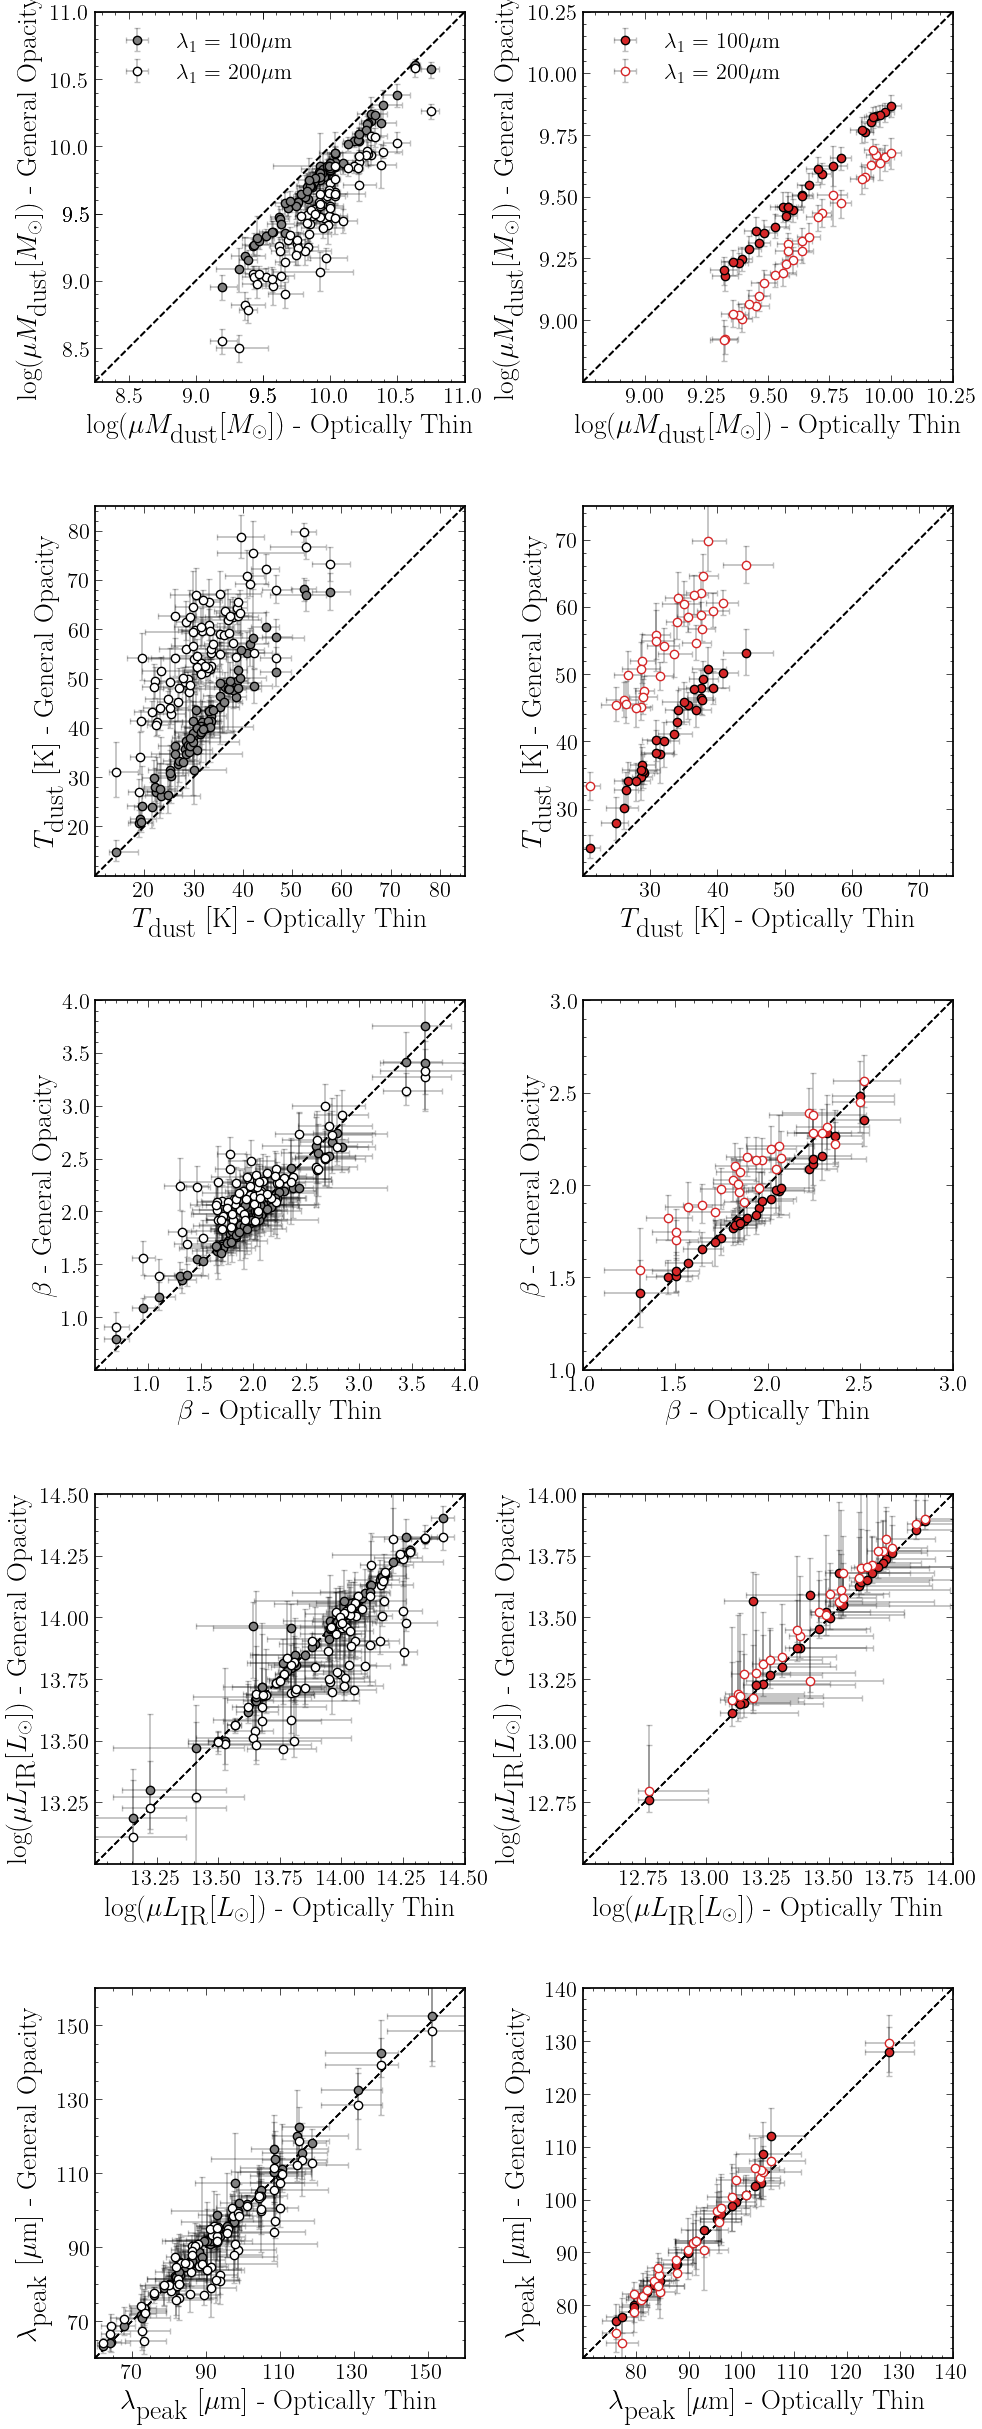

In [31]:
fig, ax = plt.subplots(5,2, figsize=(10,25))
for ax_it in range(len(ax)):
    # Get each parameter for SPT and HerBS sources
    spt_ot_param_set = spt_ot_best_list[ax_it]
    spt_ot_err_param_set = spt_ot_err_best_list[ax_it]
    spt_go_param_set = spt_go_best_list[ax_it]
    spt_go_err_param_set = spt_go_err_best_list[ax_it]
    herbs_ot_param_set = herbs_ot_best_list[ax_it]
    herbs_ot_err_param_set = herbs_ot_err_best_list[ax_it]
    herbs_go_param_set = herbs_go_best_list[ax_it]
    herbs_go_err_param_set = herbs_go_err_best_list[ax_it]

    # Plot SPT median values
    for param_it in range(len(spt_ot_param_set)):
        markers, caps, bars = ax[ax_it,0].errorbar(spt_ot_param_set[param_it], spt_go_param_set[param_it], xerr=spt_ot_err_param_set[param_it], yerr=spt_go_err_param_set[param_it], fmt='o', c='k', mec=spt_mec_list[param_it], mfc=spt_mfc_list[param_it], label=legend_labels[param_it])
        ax[ax_it,0].plot(ranges_spt[ax_it], ranges_spt[ax_it], linestyle='--', c='k')
        ax[ax_it,0].set_aspect('equal', adjustable='box')
        ax[ax_it,0].set_xlabel(x_labels[ax_it], fontsize=20)
        ax[ax_it,0].set_ylabel(y_labels[ax_it], fontsize=20)
        ax[ax_it,0].set_xlim(min(ranges_spt[ax_it]), max(ranges_spt[ax_it]))
        ax[ax_it,0].set_ylim(min(ranges_spt[ax_it]), max(ranges_spt[ax_it]))
        ax[ax_it,0].set_xticks(ticks_spt[ax_it])
        ax[ax_it,0].set_yticks(ticks_spt[ax_it])
        [bar.set_alpha(alpha) for bar in bars]
        [cap.set_alpha(alpha) for cap in caps]

    # Plot HerBS median values
    for param_it in range(len(herbs_ot_param_set)):
        markers, caps, bars = ax[ax_it,1].errorbar(herbs_ot_param_set[param_it], herbs_go_param_set[param_it], xerr=herbs_ot_err_param_set[param_it], yerr=herbs_go_err_param_set[param_it], fmt='o', c='k', mec=herbs_mec_list[param_it], mfc=herbs_mfc_list[param_it], label=legend_labels[param_it])
        ax[ax_it,1].plot(ranges_herbs[ax_it], ranges_herbs[ax_it], linestyle='--', c='k')
        ax[ax_it,1].set_aspect('equal', adjustable='box')
        ax[ax_it,1].set_xlabel(x_labels[ax_it], fontsize=20)
        ax[ax_it,1].set_ylabel(y_labels[ax_it], fontsize=20)
        ax[ax_it,1].set_xlim(min(ranges_herbs[ax_it]), max(ranges_herbs[ax_it]))
        ax[ax_it,1].set_ylim(min(ranges_herbs[ax_it]), max(ranges_herbs[ax_it]))
        ax[ax_it,1].set_xticks(ticks_herbs[ax_it])
        ax[ax_it,1].set_yticks(ticks_herbs[ax_it])
        [bar.set_alpha(alpha) for bar in bars]
        [cap.set_alpha(alpha) for cap in caps]
ax[0,0].legend(fontsize=16)
ax[0,1].legend(fontsize=16)
plt.tight_layout()
plt.savefig(os.getcwd() + '/figures/Figure_4_6.pdf', dpi=1000)
plt.show()

In [32]:
# Combine SPT and HerBS results
all_catalogue_results_df = pd.concat([spt_catalogue_results_df, herbs_catalogue_results_df])

# The typical difference in temperature between models
t_100_ot_diff = np.percentile(all_catalogue_results_df['t_go100'] - all_catalogue_results_df['t_ot'], [16,50,84])
t_200_ot_diff = np.percentile(all_catalogue_results_df['t_go200'] - all_catalogue_results_df['t_ot'], [16,50,84])

print('The 16th - 50th - 84th percentiles in the difference between T using OT and 100um models (SPT+HerBS): {:.2f} - {:.2f} - {:.2f}'.format(t_100_ot_diff[0], t_100_ot_diff[1], t_100_ot_diff[2]))
print('The 16th - 50th - 84th percentiles in the difference between T using OT and 200um models (SPT+HerBS): {:.2f} - {:.2f} - {:.2f}'.format(t_200_ot_diff[0], t_200_ot_diff[1], t_200_ot_diff[2]))

# The typical difference in log(mu*dust mass) between models
logmum_100_ot_diff = np.percentile(all_catalogue_results_df['logmum_ot'] - all_catalogue_results_df['logmum_go100'], [16,50,84])
logmum_200_ot_diff = np.percentile(all_catalogue_results_df['logmum_ot'] - all_catalogue_results_df['logmum_go200'], [16,50,84])

print('The 16th - 50th - 84th percentiles in the difference between logmum using OT and 100um models (SPT+HerBS): {:.2f} - {:.2f} - {:.2f}'.format(logmum_100_ot_diff[0], logmum_100_ot_diff[1], logmum_100_ot_diff[2]))
print('The 16th - 50th - 84th percentiles in the difference between logmum using OT and 200um models (SPT+HerBS): {:.2f} - {:.2f} - {:.2f}'.format(logmum_200_ot_diff[0], logmum_200_ot_diff[1], logmum_200_ot_diff[2]))

The 16th - 50th - 84th percentiles in the difference between T using OT and 100um models (SPT+HerBS): 4.97 - 7.99 - 11.09
The 16th - 50th - 84th percentiles in the difference between T using OT and 200um models (SPT+HerBS): 18.49 - 22.54 - 27.95
The 16th - 50th - 84th percentiles in the difference between logmum using OT and 100um models (SPT+HerBS): 0.11 - 0.14 - 0.18
The 16th - 50th - 84th percentiles in the difference between logmum using OT and 200um models (SPT+HerBS): 0.31 - 0.37 - 0.52
